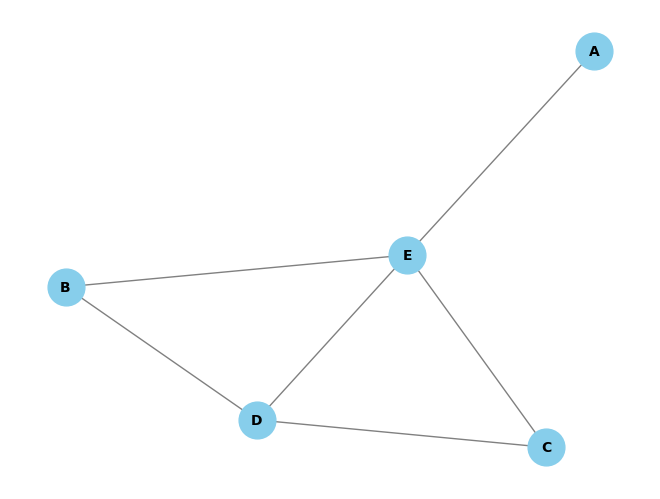

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# 创建无向图
G = nx.Graph()

# 添加节点
nodes = ['A', 'B', 'C', 'D', 'E']
G.add_nodes_from(nodes)

# 添加边（连接关系）
edges = [('A', 'E'), ('B', 'E'), ('B', 'D'), ('C', 'D'), ('C', 'E'), ('D', 'E')]
G.add_edges_from(edges)

# 可视化图
pos = nx.spring_layout(G)  # 选择布局算法
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_size=10, edge_color='gray')

In [2]:
import numpy as np

# 获取邻接矩阵
adj_matrix = nx.adjacency_matrix(G)

# 获取度矩阵
degree_matrix = np.diag(list(dict(G.degree()).values()))

print("邻接矩阵:")
print(adj_matrix.toarray())

print("\n度矩阵:")
print(degree_matrix)

邻接矩阵:
[[0 0 0 0 1]
 [0 0 0 1 1]
 [0 0 0 1 1]
 [0 1 1 0 1]
 [1 1 1 1 0]]

度矩阵:
[[1 0 0 0 0]
 [0 2 0 0 0]
 [0 0 2 0 0]
 [0 0 0 3 0]
 [0 0 0 0 4]]


In [3]:
# 添加自环
for node in nodes:
    G.add_edge(node, node)
    
# 获取邻接矩阵
adj_matrix = nx.adjacency_matrix(G)

# 获取度矩阵
degree_matrix = np.diag(list(dict(G.degree()).values()))

print("邻接矩阵:")
print(adj_matrix.toarray())

print("\n度矩阵:")
print(degree_matrix)

邻接矩阵:
[[1 0 0 0 1]
 [0 1 0 1 1]
 [0 0 1 1 1]
 [0 1 1 1 1]
 [1 1 1 1 1]]

度矩阵:
[[3 0 0 0 0]
 [0 4 0 0 0]
 [0 0 4 0 0]
 [0 0 0 5 0]
 [0 0 0 0 6]]


In [4]:
A_tilde = adj_matrix.toarray()
D_tilde = np.diag(np.array(list(dict(G.degree()).values())) - 1) # 注意GCN中的自环增加一条边，度数增加1

print(A_tilde)
print(D_tilde)

[[1 0 0 0 1]
 [0 1 0 1 1]
 [0 0 1 1 1]
 [0 1 1 1 1]
 [1 1 1 1 1]]
[[2 0 0 0 0]
 [0 3 0 0 0]
 [0 0 3 0 0]
 [0 0 0 4 0]
 [0 0 0 0 5]]


In [5]:
np.linalg.inv(D_tilde)

array([[0.5       , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.33333333, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.25      , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.2       ]])

In [6]:
np.linalg.inv(D_tilde) @ A_tilde

array([[0.5       , 0.        , 0.        , 0.        , 0.5       ],
       [0.        , 0.33333333, 0.        , 0.33333333, 0.33333333],
       [0.        , 0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.        , 0.25      , 0.25      , 0.25      , 0.25      ],
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ]])

In [7]:
np.linalg.inv(D_tilde) @ A_tilde @ np.linalg.inv(D_tilde)

array([[0.25      , 0.        , 0.        , 0.        , 0.1       ],
       [0.        , 0.11111111, 0.        , 0.08333333, 0.06666667],
       [0.        , 0.        , 0.11111111, 0.08333333, 0.06666667],
       [0.        , 0.08333333, 0.08333333, 0.0625    , 0.05      ],
       [0.1       , 0.06666667, 0.06666667, 0.05      , 0.04      ]])

In [8]:
np.linalg.inv(np.sqrt(D_tilde)) @ A_tilde @ np.linalg.inv(np.sqrt(D_tilde))

array([[0.5       , 0.        , 0.        , 0.        , 0.31622777],
       [0.        , 0.33333333, 0.        , 0.28867513, 0.25819889],
       [0.        , 0.        , 0.33333333, 0.28867513, 0.25819889],
       [0.        , 0.28867513, 0.28867513, 0.25      , 0.2236068 ],
       [0.31622777, 0.25819889, 0.25819889, 0.2236068 , 0.2       ]])

GCN的规范化，使得中心节点本身和邻居特征聚合的权重发生变化；是一种根据度矩阵（连接数）加权的聚合方式；
对中心节点而言，邻居的度越大，传递给中心节点的信息越少。

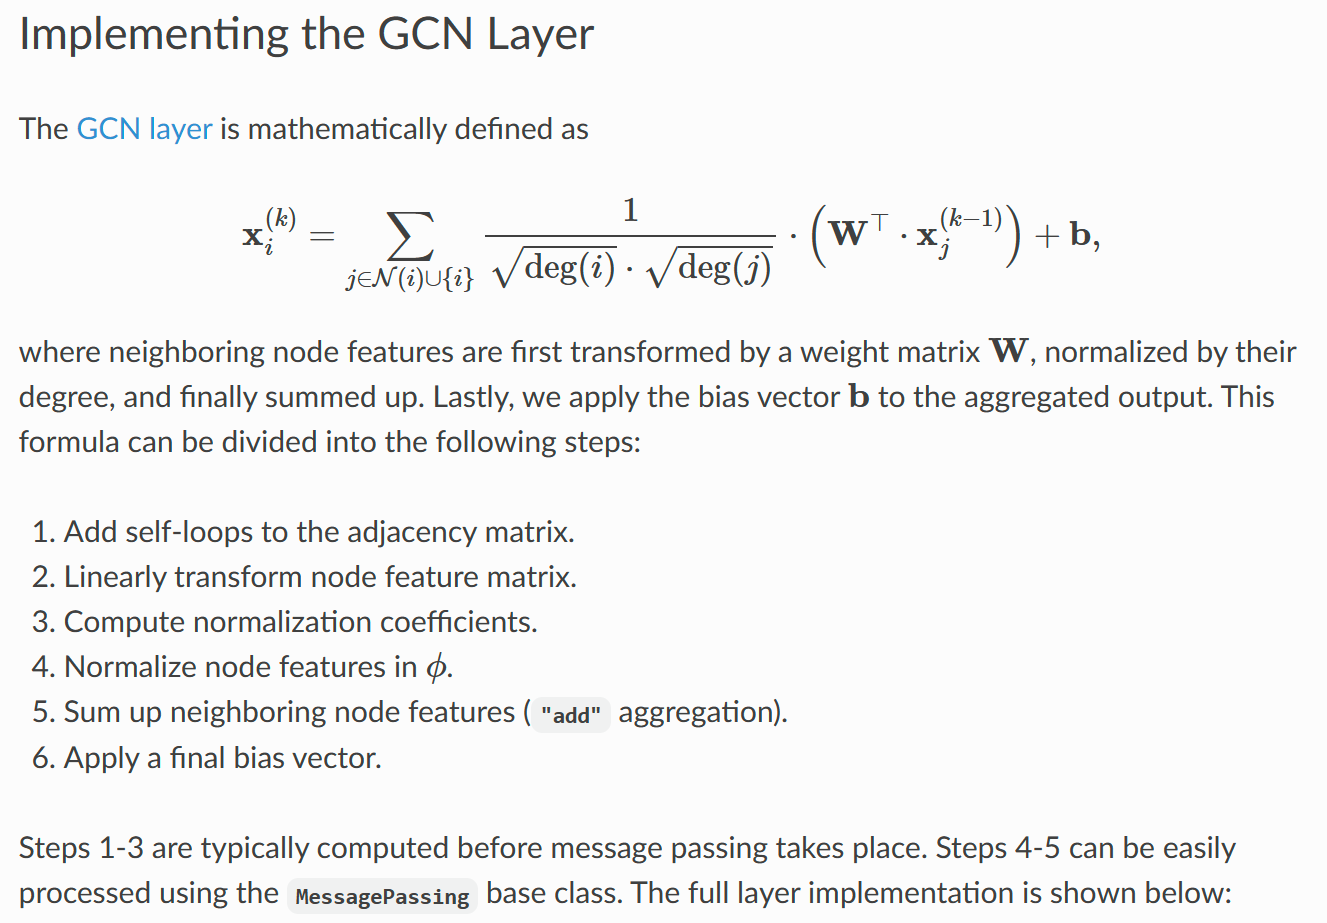

In [9]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)

        # Step 6: Apply a final bias vector.
        out += self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j